# 1. Import Libraries and data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
# Import the dataset
dataset_df = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
dataset_df.head()
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


# 2. EDA

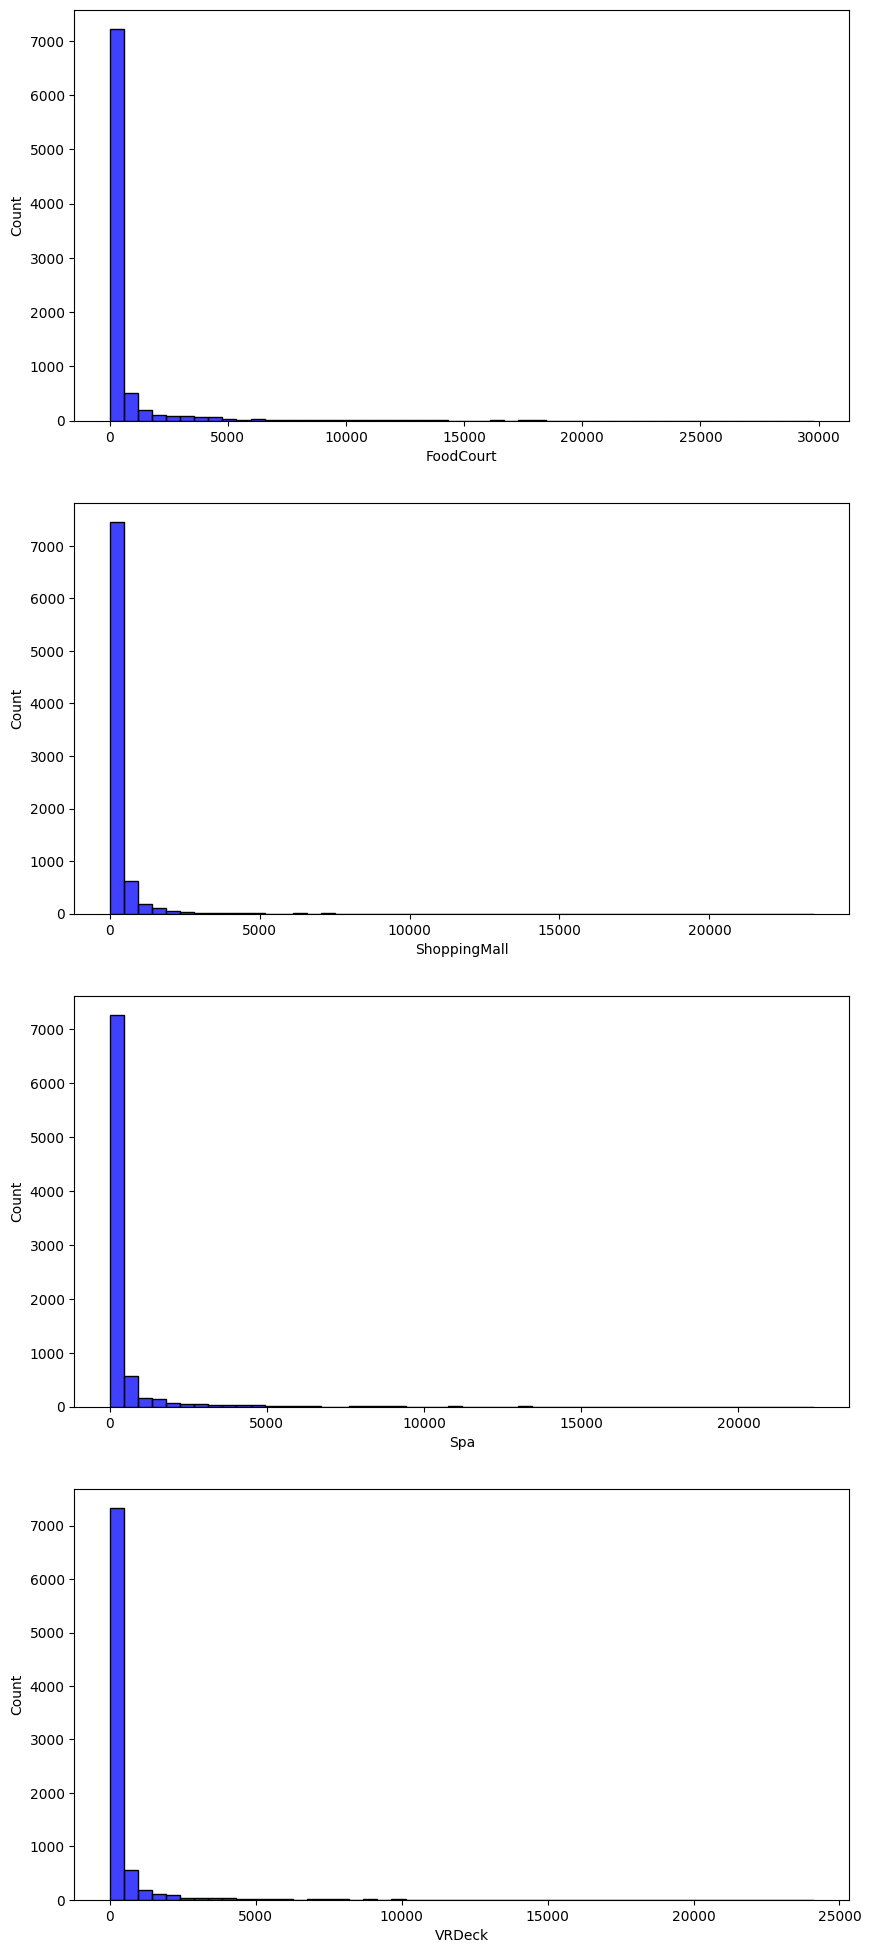

In [3]:
fig,ax = plt.subplots(4,1,figsize=(10,10))
plt.subplots_adjust(top = 2)

sns.histplot(dataset_df['FoodCourt'], color='b', bins=50, ax=ax[0]);
sns.histplot(dataset_df['ShoppingMall'], color='b', bins=50, ax=ax[1]);
sns.histplot(dataset_df['Spa'], color='b', bins=50, ax=ax[2]);
sns.histplot(dataset_df['VRDeck'], color='b', bins=50, ax=ax[3]);

In [4]:
# Drop features that are not explanatory 
df = dataset_df.copy()
df.drop(["PassengerId","Name"],axis = 1,inplace= True)
df.head(10)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True
5,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,True
6,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,True
7,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,True
8,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,True
9,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,True


In [5]:
#Numerical variable: One-hot or label encod?

print(df.Destination.value_counts())
categorical_columns = [col for col in df.columns if df[col].dtype == "object"]
print(categorical_columns)
for category in categorical_columns: 
    print(df[category].value_counts())

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64
['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']
HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64
CryoSleep
False    5439
True     3037
Name: count, dtype: int64
Cabin
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: count, Length: 6560, dtype: int64
Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64
VIP
False    8291
True      199
Name: count, dtype: int64


In [6]:
#NA values investigtation
df.isna().sum()

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

In [7]:
## Let's fill the numerical features' missing values with 0 

df[["VIP", "RoomService",'CryoSleep',"FoodCourt","ShoppingMall","Spa", "VRDeck"]] = df[["VIP","RoomService",'CryoSleep',"FoodCourt","ShoppingMall","Spa", "VRDeck"]].fillna(value=0)

In [8]:
## note that TF-DF do not tolerate boolean values (i.e True/Fasle). So I would suggest to change it to 0,1 for column CryoSleep VIP,and Transported

df[["CryoSleep", "VIP", "Transported"]] = df[["CryoSleep", "VIP", "Transported"]].astype(int)

In [9]:
# Split the 'Cabin' column into separate columns
df[['Deck', 'Cabin Number', 'Cabin Side']] = df['Cabin'].str.split('/', expand=True)

cabin_side_mapping = {
    'P': 'Port',
    'S': 'Starboard'
}

df['Cabin Side'] = df['Cabin Side'].map(cabin_side_mapping)

# Drop the original 'Cabin' column
df.drop('Cabin', axis=1, inplace=True)

In [10]:
# Let's replace the missing values by "missing":

df[["HomePlanet", "Destination"]] = df[["HomePlanet", "Destination"]].fillna(value="missing")
df.dropna(axis=0,inplace=True)
df["Cabin Number"] = df["Cabin Number"].astype(int)

In [11]:
## Create bin for age

# Define age bins
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

# Create a new column for age bins
df['Age_Bin'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
df.drop("Age",axis=1,inplace=True)

df.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin Number,Cabin Side,Age_Bin
0,Europa,0,TRAPPIST-1e,0,0.0,0.0,0.0,0.0,0.0,0,B,0,Port,30-40
1,Earth,0,TRAPPIST-1e,0,109.0,9.0,25.0,549.0,44.0,1,F,0,Starboard,20-30
2,Europa,0,TRAPPIST-1e,1,43.0,3576.0,0.0,6715.0,49.0,0,A,0,Starboard,50-60
3,Europa,0,TRAPPIST-1e,0,0.0,1283.0,371.0,3329.0,193.0,0,A,0,Starboard,30-40
4,Earth,0,TRAPPIST-1e,0,303.0,70.0,151.0,565.0,2.0,1,F,1,Starboard,10-20


In [12]:
#log-scale variables that are asymmetrically distributed

variables_to_log_scale = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

for var in variables_to_log_scale:
    df[f'log_{var}'] = np.log1p(df[var])  # log1p computes log(1 + x), which is useful for variables with zero values
    
    df.drop(var,axis=1,inplace=True)

# 3. Data Pre-processing and Model Selection

## 3.1 Pre-processing

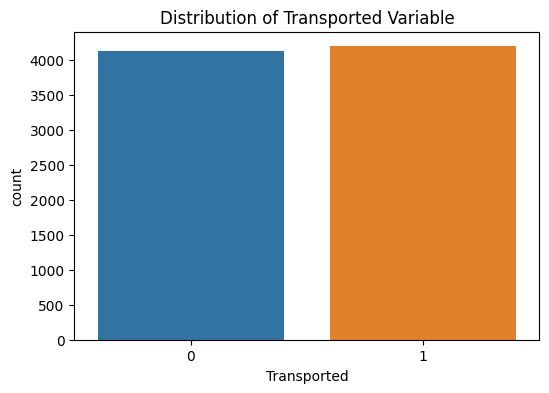

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Further Data Exploration
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Transported')
plt.title('Distribution of Transported Variable')
plt.show()

# Data Splitting
from sklearn.model_selection import train_test_split

# Assuming 'Transported' is the target variable
X = df.drop('Transported', axis=1)
y = df['Transported']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical columns
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[categorical_cols]))
OH_cols_val = pd.DataFrame(OH_encoder.transform(X_val[categorical_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_val.index = X_val.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(categorical_cols, axis=1)
num_X_val = X_val.drop(categorical_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_val = pd.concat([num_X_val, OH_cols_val], axis=1)# Model Training

# To have all the column names to be string
X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)

X_train.dropna(inplace=True)
X_val.dropna(inplace=True)
y_train = y_train[X_train.index]
y_val = y_val[X_val.index]# Ensure labels match the training data

## 3.1 Sample Pre-processing (to avoid long training of models) 

In [14]:
# Sample a fraction (e.g., 20%) of the training and validation data
sample_fraction = 0.2

X_train_sample = X_train.sample(frac=sample_fraction, random_state=42)
y_train_sample = y_train[X_train_sample.index]

X_val_sample = X_val.sample(frac=sample_fraction, random_state=42)
y_val_sample = y_val[X_val_sample.index]

# Combine features and label for training data
train_df_with_label_sample = X_train_sample.copy()
train_df_with_label_sample['Transported'] = y_train_sample

# Combine features and label for validation data
val_df_with_label_sample = X_val_sample.copy()
val_df_with_label_sample['Transported'] = y_val_sample

# Convert the Pandas DataFrame into a TensorFlow dataset
train_data_sample = tfdf.keras.pd_dataframe_to_tf_dataset(train_df_with_label_sample, task=tfdf.keras.Task.CLASSIFICATION, label="Transported")
val_data_sample = tfdf.keras.pd_dataframe_to_tf_dataset(val_df_with_label_sample, task=tfdf.keras.Task.CLASSIFICATION, label="Transported")

## 3.2 TensorFlow Decision Forest

In [15]:
# Initialize and train the model
model_tfdf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
model_tfdf.fit(train_data_sample)

# Evaluate the model
evaluation_tfdf = model_tfdf.evaluate(val_data_sample)

predictions_tfdf = model_tfdf.predict(val_data_sample)
predicted_labels_tfdf = (predictions_tfdf > 0.5).astype(int)
accuracy_tfdf = accuracy_score(y_val_sample, predicted_labels_tfdf)
print(f"Validation Accuracy  of the TensorFlow Decision Forest model on Sampled Data: {accuracy_tfdf}")

Use /tmp/tmp2dh1fnew as temporary training directory
Reading training dataset...
Training dataset read in 0:00:04.953635. Found 1331 examples.
Training model...


[INFO 23-10-19 16:41:06.0629 UTC kernel.cc:1243] Loading model from path /tmp/tmp2dh1fnew/model/ with prefix c99e80db4b3849e6


Model trained in 0:00:01.029108
Compiling model...


[INFO 23-10-19 16:41:06.3604 UTC decision_forest.cc:660] Model loaded with 300 root(s), 69504 node(s), and 27 input feature(s).
[INFO 23-10-19 16:41:06.3605 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-10-19 16:41:06.3605 UTC kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 0s 91ms/step
Validation Accuracy  of the TensorFlow Decision Forest model on Sampled Data: 0.8048048048048048


## 3.3 Gradient Boosted Trees

In [16]:
model_gb = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)
model_gb.fit(train_data_sample)
# Evaluate the model
evaluation_gb = model_gb.evaluate(val_data_sample)

predictions_gb = model_gb.predict(val_data_sample)
predicted_labels_gb = (predictions_gb > 0.5).astype(int)
accuracy_gb = accuracy_score(y_val_sample, predicted_labels_gb)
print(f"Validation Accuracy of the Gradient Boosted DF on Sampled Data: {accuracy_gb}")

Use /tmp/tmpw3bes6uy as temporary training directory
Reading training dataset...


[WARNING 23-10-19 16:41:09.3166 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-19 16:41:09.3167 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-19 16:41:09.3167 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.441726. Found 1331 examples.
Training model...
Model trained in 0:00:00.602417
Compiling model...


[INFO 23-10-19 16:41:10.3655 UTC kernel.cc:1243] Loading model from path /tmp/tmpw3bes6uy/model/ with prefix 76130a78f5e6438f
[INFO 23-10-19 16:41:10.3715 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 76ms/step
Validation Accuracy of the Gradient Boosted DF on Sampled Data: 0.7897897897897898


## 3.4 Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter = 10000)

age_mapping = {
    '0-10': 0,
    '10-20': 1,
    '20-30': 2,
    '30-40': 3,
    '40-50': 4,
    '50-60': 5,
    '60-70': 6,
    '70-80': 7,
    '80-90': 8,
    '90-100':9,
   
    # ... add other age bins as needed
}

X_train_sample['Age_Bin'] = X_train_sample['Age_Bin'].map(age_mapping)
X_val_sample['Age_Bin'] = X_val_sample['Age_Bin'].map(age_mapping)

log_reg.fit(X_train_sample,y_train_sample)
log_reg_accuracy = log_reg.score(X_val_sample, y_val_sample)
print(f"Validation Accuracy for Logistic Regression: {log_reg_accuracy}")

Validation Accuracy for Logistic Regression: 0.7957957957957958


## 3.5 Support Vector Machine

In [18]:
from sklearn.svm import SVC

# Initialize and train the SVM classifier
svm_clf = SVC(probability=True)  # probability=True to ensure we can get probability estimates for the voting classifier
svm_clf.fit(X_train_sample, y_train_sample)

# Evaluate the model
svm_accuracy = svm_clf.score(X_val_sample, y_val_sample)
print(f"Validation Accuracy for SVM Classifier: {svm_accuracy}")

Validation Accuracy for SVM Classifier: 0.5885885885885885


In [19]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# 3. Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train_sample, y_train_sample)

# 4. Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=100)
gb_clf.fit(X_train_sample, y_train_sample)

# Evaluate the model
rf_accuracy = rf_clf.score(X_val_sample, y_val_sample)
print(f"Validation Accuracy for Random Forest Classifier: {rf_accuracy}")

# Evaluate the model
gb_accuracy = gb_clf.score(X_val_sample, y_val_sample)
print(f"Validation Accuracy for Gradient Boosted Classifier: {gb_accuracy}")

Validation Accuracy for Random Forest Classifier: 0.8138138138138138
Validation Accuracy for Gradient Boosted Classifier: 0.7867867867867868


## 3.6 Ensemble Learning

In [20]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_reg), 
        ('svm', svm_clf), 
        ('rf', rf_clf), 
        ('gb', gb_clf)
    ], 
    voting='hard'
)
voting_clf.fit(X_train_sample, y_train_sample)

#Evaluate the model
voting_accuracy = voting_clf.score(X_val_sample, y_val_sample)
print(f"Validation Accuracy for Voting Classifier: {voting_accuracy}")


Validation Accuracy for Voting Classifier: 0.8048048048048048


# The code below is to run only when I'm happy with the accuracy of the sample (takes a while to run)

In [21]:
#Validation Accuracy: 0.8202388434946575

### Let's try to implement a Tensorflow Decison Forest (I still need to review what is Gradient Boosted Trees and Cart)

# Combine features and label for training data
train_df_with_label = X_train.copy()
train_df_with_label['Transported'] = y_train

# Combine features and label for validation data
val_df_with_label = X_val.copy()
val_df_with_label['Transported'] = y_val

# Convert the Pandas DataFrame into a TensorFlow dataset
train_data = tfdf.keras.pd_dataframe_to_tf_dataset(train_df_with_label, task=tfdf.keras.Task.CLASSIFICATION, label="Transported")
val_data = tfdf.keras.pd_dataframe_to_tf_dataset(val_df_with_label, task=tfdf.keras.Task.CLASSIFICATION, label="Transported")

# Initialize and train the model
model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
model.fit(train_data)

# Evaluate the model
evaluation = model.evaluate(val_data)

predictions = model.predict(val_data)
predicted_labels_best = (predictions > 0.5).astype(int)
from sklearn.metrics import accuracy_score
accuracy_best = accuracy_score(y_val, predicted_labels_best)
print(f"Validation Accuracy: {accuracy_best}")

Use /tmp/tmpx6qgnzo0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.591305. Found 6655 examples.
Training model...


[INFO 23-10-19 16:41:17.9943 UTC kernel.cc:1243] Loading model from path /tmp/tmpx6qgnzo0/model/ with prefix 0a220fee6f8a4bd4


Model trained in 0:00:04.301574
Compiling model...


[INFO 23-10-19 16:41:19.1327 UTC decision_forest.cc:660] Model loaded with 300 root(s), 268070 node(s), and 26 input feature(s).
[INFO 23-10-19 16:41:19.1328 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-10-19 16:41:19.1328 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 35ms/step
Validation Accuracy: 0.7950721153846154


# 3. Test the TFDF and Gradient Boosted

## 3.1 Prepare the Test Set for the TF-DF and Gradient Booster

In [22]:
# Load the test dataset
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

submission_id = test_df["PassengerId"]
test_df.drop(["PassengerId","Name"],axis = 1,inplace= True)

# Replace NaN values with zero and "missing values" and drop the rest
test_df[["VIP", "RoomService",'CryoSleep',"FoodCourt","ShoppingMall","Spa", "VRDeck"]] = test_df[["VIP","RoomService",'CryoSleep',"FoodCourt","ShoppingMall","Spa", "VRDeck"]].fillna(value=0)
test_df[["HomePlanet", "Destination"]] = test_df[["HomePlanet", "Destination"]].fillna(value="missing")

# Creating New Features - Deck, Cabin_num and Side from the column Cabin and remove Cabin
test_df[["Deck", "Cabin Number", "Cabin Side"]] = test_df["Cabin"].str.split("/", expand=True)
cabin_side_mapping = {
    'P': 'Port',
    'S': 'Starboard'
}

test_df['Cabin Side'] = test_df['Cabin Side'].map(cabin_side_mapping)
test_df.drop('Cabin', axis=1,inplace =True)
test_df['Cabin Number'] = test_df['Cabin Number'].fillna(-1).astype('int64')
# Convert boolean to 1's and 0's
test_df['VIP'] = test_df['VIP'].astype(int)
test_df['CryoSleep'] = test_df['CryoSleep'].astype(int)

## Create bin for age
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

# Create a new column for age bins
test_df['Age_Bin'] = pd.cut(test_df['Age'], bins=bins, labels=labels, right=False)
test_df['Age_Bin'] = test_df['Age_Bin'].cat.add_categories(['Unknown']).fillna('Unknown')
test_df.drop("Age",axis=1,inplace=True)

# Identify categorical columns
categorical_cols = [col for col in test_df.columns if test_df[col].dtype == 'object']

# Apply one-hot encoder to each column with categorical data
OH_cols_train = pd.DataFrame(OH_encoder.transform(test_df[categorical_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = test_df.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = test_df.drop(categorical_cols, axis=1)

# Add one-hot encoded columns to numerical features
test_df = pd.concat([num_X_train, OH_cols_train], axis=1)

# To have all the column names to be string
test_df.columns = test_df.columns.astype(str)

# Apply log transformation (adding 1 to handle zeros)
variables_to_log_scale = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

for var in variables_to_log_scale:
    test_df[f'log_{var}'] = np.log1p(test_df[var])
    test_df.drop(var,axis=1,inplace=True)

## 3.2 Test

In [23]:
# Convert pd dataframe to tf dataset
test_df = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

# Get the predictions for testdata
predictions = model.predict(test_df)
n_predictions = (predictions > 0.5).astype(bool)
output = pd.DataFrame({'PassengerId': submission_id,
                       'Transported': n_predictions.squeeze()})

output.head()

5/5 [==============================] - 0s 40ms/step


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [24]:
sample_submission_df = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
sample_submission_df['Transported'] = n_predictions
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


# 4 Test Set the ensemble classifier

## 4.1 Prepare the Test Set for the ensemble classifier

In [41]:
# Load the test dataset
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

submission_id = test_df["PassengerId"]
test_df.drop(["PassengerId","Name"],axis = 1,inplace= True)

# Replace NaN values with zero and "missing values" and drop the rest
test_df[["VIP", "RoomService",'CryoSleep',"FoodCourt","ShoppingMall","Spa", "VRDeck"]] = test_df[["VIP","RoomService",'CryoSleep',"FoodCourt","ShoppingMall","Spa", "VRDeck"]].fillna(value=0)
test_df[["HomePlanet", "Destination"]] = test_df[["HomePlanet", "Destination"]].fillna(value="missing")

# Creating New Features - Deck, Cabin_num and Side from the column Cabin and remove Cabin
test_df[["Deck", "Cabin Number", "Cabin Side"]] = test_df["Cabin"].str.split("/", expand=True)
cabin_side_mapping = {
    'P': 'Port',
    'S': 'Starboard'
}

test_df['Cabin Side'] = test_df['Cabin Side'].map(cabin_side_mapping)
test_df.drop('Cabin', axis=1,inplace =True)
test_df['Cabin Number'] = test_df['Cabin Number'].fillna(-1).astype('int64')
# Convert boolean to 1's and 0's
test_df['VIP'] = test_df['VIP'].astype(int)
test_df['CryoSleep'] = test_df['CryoSleep'].astype(int)

## Create bin for age
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create a new column for age bins
test_df['Age_Bin'] = pd.cut(test_df['Age'], bins=bins, labels=labels, right=False)
test_df['Age_Bin'] = test_df['Age_Bin'].cat.add_categories(['Unknown']).fillna('Unknown')
test_df.drop("Age",axis=1,inplace=True)
test_df['Age_Bin'].replace('Unknown', 10, inplace=True)
test_df['Age_Bin'] = test_df['Age_Bin'].astype(int)

# Apply log transformation (adding 1 to handle zeros)
variables_to_log_scale = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

for var in variables_to_log_scale:
    test_df[f'log_{var}'] = np.log1p(test_df[var])
    test_df.drop(var,axis=1,inplace=True)# Identify categorical columns
categorical_cols = [col for col in test_df.columns if test_df[col].dtype == 'object']

# Apply one-hot encoder to each column with categorical data
OH_cols_train = pd.DataFrame(OH_encoder.transform(test_df[categorical_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = test_df.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = test_df.drop(categorical_cols, axis=1)

# Add one-hot encoded columns to numerical features
test_df = pd.concat([num_X_train, OH_cols_train], axis=1)

# To have all the column names to be string
test_df.columns = test_df.columns.astype(str)

## 4.2 Test

In [43]:
# Get the predictions for testdata
predictions = voting_clf.predict(test_df)
n_predictions = (predictions > 0.5).astype(bool)
output = pd.DataFrame({'PassengerId': submission_id,
                       'Transported': n_predictions.squeeze()})

output.head()

sample_submission_df = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
sample_submission_df['Transported'] = n_predictions
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,True
